<a href="https://colab.research.google.com/github/takao-takenouchi/dp_tutorial/blob/main/DP_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Differential Privacyの基本

## はじめに

本チュートリアルはPyDPを利用し、Differential Privacyの概要の理解を目指します。PyDPとは、OpenMindが開発しているApache License 2.0で利用可能なOSSライブラリで、Google's Differential Privacy libraryをサポートし、Laplaceノイズに対応し、整数と浮動小数点に対応しています。詳細は、PyDPのサイトを参照ください。
https://pydp.readthedocs.io/en/latest/index.html

本チュートリアルは、以下を参考に作成しています。
*   PyDPのチュートリアル
    * OM PriCon2020 Tutorial: Differential Privacy Using PyDP - Chinmay Shah　
        * https://www.youtube.com/watch?v=15OgnNsvEo8
        * https://github.com/google/differential-privacy/tree/main/examples/java
*   GoogleのDifferential Privacyのライブラリのexample
    * https://github.com/google/differential-privacy/tree/main/examples/java


## チュートリアルの全体構成
本チュートリアルは2つのPartに分かれています。
*   Part1: Differential Privacyの基本
*   Part2: プライバシーパラメータ（Epsilon、Contribution）

## 「Part1: Differential Privacyの基本」の学習内容

Part1では以下の内容について学びます。
*   データベースの1レコードの変化により、プライバシー侵害のリスク
*   差分プライバシーを満たすノイズを適用することで、上記リスクを低減できること
*   ノイズ付加による有用性の低下(元データからどの程度変化するか)
*   epsilonとsensitivity(何を隠すか)
*   Privacy Budget(プライバシーの予算)

## *サンプルコード*

### 準備

In [1]:
!pip install python-dp # PyDPをインストール

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pydp as dp # dp (Differential Privacy) としてをインポート
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, Count, Max
import pandas as pd
import statistics # differential privacyを使わずに集計などをするためにインポート
import numpy as np
import matplotlib.pyplot as plt

#### データを取得 (OpenMindのPyDPのチュートリアルのデータを利用)

1000行 x 6列の営業成績のデータで、各行に営業担当者のデータが保存されています。
今回は特に、5列目のsales_amountが、営業秘密としてもプライバシーとしても他人知られたくないとします。

In [3]:
# OpenMindのPyDPのチュートリアルのデータがpublickなgithubにあるため取得
url = 'https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial_4-Launch_demo/data/01.csv'
original_dataset = pd.read_csv(url,sep=",", engine = "python")
print("data set size: ", original_dataset.shape)
original_dataset.head()

data set size:  (1000, 6)


,id,first_name,last_name,email,sales_amount,state
0,1,Osbourne,Gillions,ogillions0@feedburner.com,31.94,Florida
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida



### データセットから1行削除

ここで、仮に最初の行の営業担当者(Osbourneさん)が退職したとして、削除します。
その結果、削除前のデータセット対する集計結果と、削除後のデータセットの集計結果の差から、削除された個人のプライバシー情報が推測される恐れがあることを示したいと思います。

In [4]:
# rupdated_datasetを、削除したデータセットとします。元のデータセットはoriginal_datasetです。
updated_dataset = original_dataset.copy()
updated_dataset = updated_dataset[1:] # 0行目を含めず1行目以降をupdated_datasetに入れているため、このデータセットには以下の行がないはずです
# Osbourne	Gillions	ogillions0@feedburner.com	31.94	Florida

In [5]:
# まずはoriginal_datasetを確認します
original_dataset.head()

,id,first_name,last_name,email,sales_amount,state
0,1,Osbourne,Gillions,ogillions0@feedburner.com,31.94,Florida
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida


In [6]:
# 続いてoriginal_datasetを確認します
updated_dataset.head()

,id,first_name,last_name,email,sales_amount,state
1,2,Glynn,Friett,gfriett1@blog.com,12.46,California
2,3,Jori,Blockley,jblockley2@unesco.org,191.14,Colorado
3,4,Garald,Dorian,gdorian3@webeden.co.uk,126.58,Texas
4,5,Mercy,Pilkington,mpilkington4@jugem.jp,68.32,Florida
5,6,Elle,McConachie,emcconachie5@census.gov,76.91,Texas


#### 集計例1: 両方のデータセットについて合計(Sum)の差からのプライバシー侵害

元のデータセット(`original_dataset`)と、1行削除したデータセット(`updated_dataset`)について、それぞれ`sales_amount`の合計を計算します。

そして、その合計の差を計算すると、削除された行の`sales_amount`がわかってしまいます。

ここで、もし攻撃者（プライバシーに関わる情報を知りたいと考えている人）が、削除された行がOsbourneであることが知っていたとしたら(先日退職したのがOsbourne１名だけだったと知っていたとしたら)、この差の値が、Osbourneの`sales_amount`であると推測できてしまいます。

In [7]:
# 各データセットのsales_amountのsumを計算
sum_original_dataset = sum(original_dataset['sales_amount'].to_list())
sum_updated_dataset = sum(updated_dataset['sales_amount'].to_list())
# 差を計算
sales_amount_Osbourne = sum_original_dataset - sum_updated_dataset
# floatの計算時の誤差があるため、小数点2桁目で四捨五入
sales_amount_Osbourne = round(sales_amount_Osbourne, 2)
print("sum_original_dataset - sum_updated_dataset = ", sales_amount_Osbourne)
# 一応original_datasetで一致することを確認
assert sales_amount_Osbourne == original_dataset.iloc[0, 4]

sum_original_dataset - sum_updated_dataset =  31.94


#### Differential Privacyによるプライバシー侵害の抑制

このような1行の差によるプライバシー侵害が起こる可能性あるため、Differential Privacy(DP)の考え方を適用し、合計値に適切なノイズを加えます。

以降では、元のデータセット(`original_dataset`)と、1行削除したデータセット(`updated_dataset`)について適切なノイズを入れることで、ノイズ入りの合計値であると区別ができないことを示していきます。

In [8]:
# まずは、original_datasetについて、ノイズ入りの合計値を得ます。
# 
# PyDPのBoundedSumを用いてノイズ付きの合計値を計算します。
# BoundedSumには、epsilonの値、1行の最小値と最大値を指定できます。なお、数値のdata typeも指定できます。
# ここでは仮に、epsilonを1.5、sales_amountの最小値を5、最大値を250と設定します。
bs_original_dataset = BoundedSum(epsilon= 1.5, lower_bound =  5, upper_bound = 250, dtype ='float')

# ノイズを入れた結果を得ます
sum_original_dataset_dp = bs_original_dataset.quick_result(original_dataset['sales_amount'].to_list()) 

# 続いて、同様にupdated_datasetについて、ノイズ入りの合計値を得ます。
bs_updated_dataset = BoundedSum(epsilon= 1.5, lower_bound =  5, upper_bound = 250, dtype ='float')
sum_updated_dataset_dp = bs_updated_dataset.quick_result(updated_dataset['sales_amount'].to_list()) 

# わかりやすさのため全て少数点2桁目でroundします
sum_original_dataset = round(sum_original_dataset, 2)
sum_original_dataset_dp = round(sum_original_dataset_dp, 2)
sum_updated_dataset_dp = round(sum_updated_dataset_dp, 2)

#### 結果を確認
 
まずは、結果を見てみると、originalなノイズなしのデータと比較して、両方ともノイズが入っています。

また、ノイズが入った両方のデータは、どちらが削除したデータセットからの集計値なのか区別は困難そうです。

ノイズが入ったデータに対して差をとっても、ノイズなしのデータでの差とは異なります。

In [9]:
print("Sum of sales_value in the orignal Dataset: {}".format(sum_original_dataset))
print("Sum of sales_value in the orignal Dataset using DP: {}".format(sum_original_dataset_dp))
print("Sum of sales_value in the updated Dataset using DP: {}".format(sum_updated_dataset_dp))

print("Difference in sum using DP: {}".format( round(sum_original_dataset_dp - sum_updated_dataset_dp, 2)))
print("Difference of actual value: {}".format(sales_amount_Osbourne))

Sum of sales_value in the orignal Dataset: 127931.38
Sum of sales_value in the orignal Dataset using DP: 128001.52
Sum of sales_value in the updated Dataset using DP: 127963.82
Difference in sum using DP: 37.7
Difference of actual value: 31.94


グラフで見てもその様子がわかります。

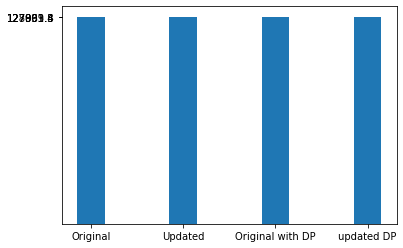

In [10]:
top=[('Original', sum_original_dataset), ('Updated', sum_updated_dataset), ('Original with DP', sum_original_dataset_dp), ('updated DP', sum_updated_dataset_dp)]

# originalとの差を計算したバージョン
#top=[('Original', 0), ('Updated', sum_updated_dataset - sum_original_dataset), ('Original with DP', sum_original_dataset_dp - sum_original_dataset), ('updated DP', sum_updated_dataset_dp - sum_original_dataset)]


labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 0.3

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels)
plt.yticks(ys)
plt.show()


### epsilonやsensitivityの説明

先ほどは、
` BoundedSum(epsilon= 1.5, lower_bound =  5, upper_bound = 250, dtype ='float') `
と、とりあえず設定していましたが、詳細を説明します。

epsilonは、DPのパラメータで、3.5以下が望ましいとされています。

lower_boundとupper_boundは、sensitivityに関係します。
sensitivityは、何を隠すかに関わり、今回はある1行（ある一人）についての変化（人が増えた・減った、sales_valueが増えた・減った）を隠したいということになります。
lower_boundとupper_boundを設定することで、この変化(sensitivity)を`upper_bound - lower_bound` と設定することになります。つまり今回は、250 - 5 = 245 となります。



### 各自で試す

*   上記のコードを何度か動かし、毎回ノイズが変わること、どの程度変わるかなど確かめてください。
*   epsilonの値を変化させ、ノイズがどのように変わるか確かめてください。(例： 5, 10と増やしたり、0.1, 0.01と減らしたり)
*   同様にupper_boundやlower_boundを変えてください。



## 集計例2: 両方のデータセットについてカウント(count)の差からのプライバシー侵害

先ほどは、合計値からのプライバシー侵害でしたが、count(行数)からのプライバシー侵害の可能性もあります。もし攻撃者が、毎日行数を得れるとして、この会社の退職の時期を知りたいとしていた場合、行数が1行減っていたら退職したのだとわかります。

これを防ぐには、行数にDifferential Privacyを満たすノイズを加えることで、推測を困難にできます。

なお、countの場合は、sensitivityは1です。

In [11]:
# まずはoriginal_datasetについて計算
# DPノイズを入れないcountを計算
count_original_dataset = len(original_dataset.id.tolist())
# DPノイズを入れたcountを計算
c_original_dataset = Count(epsilon= 0.5)
count_original_dataset_dp = c_original_dataset.quick_result(original_dataset.id.tolist())

# 続いてupdate_datasetについても同様に計算
count_updated_dataset = len(updated_dataset.id.tolist())
c_updated_dataset = Count(epsilon= 0.5)
count_updated_dataset_dp = c_updated_dataset.quick_result(updated_dataset.id.tolist())


print("count_original_dataset=",count_original_dataset)
print("count_updated_dataset=",count_updated_dataset)
print("count_original_dataset_dp=",count_original_dataset_dp)
print("count_updated_dataset_dp=",count_updated_dataset_dp)

count_original_dataset= 1000
count_updated_dataset= 999
count_original_dataset_dp= 1000
count_updated_dataset_dp= 1002


同様に、epsilonを変化させてみると良いと思います。先ほどのSumはepsilonを1.5にしていましたので、試しに1.5にするとどうでしょうか？

## Privacy budgetについて

続いてPrivacy budgetについて説明します。

PyDPではPrivacy budgetの簡単な管理が可能です。最初にPrivacy budgetを設定し、ノイズ入りの集計をする際に、どの程度Privacy budgetを消費するか設定可能です。
そして、最初に設定Privacy budgetがなくなったら、集計ができなくするような処理が可能です。


In [12]:
c_original_dataset = Count(epsilon= 3.0)
dp = c_original_dataset
print("original count=", len(original_dataset))
print("privacy_budget_left=", dp.privacy_budget_left())

# データを入れる
dp.add_entries(original_dataset.id.tolist())
# Privacy Budgetを50%消費して計算させる
count1 = dp.result(0.5)
print("count1=", count1)
print("privacy_budget_left=", dp.privacy_budget_left())

# 1名が追加されたとする。そして、さらにPrivacy Budgetを50%消費して計算させる。
dp.add_entries([1])
count2 = dp.result(0.5)
print("count2=", count2)
print("privacy_budget_left=", dp.privacy_budget_left())

# さらに1名追加となり、もう一度計算しようとしてもエラーとなる
#dp.add_entries([1])
#count3 = dp.result(0.5)


original count= 1000
privacy_budget_left= 1.0
count1= 997
privacy_budget_left= 0.5
count2= 1002
privacy_budget_left= 0.0


### まとめ:

Differential Privacyを満たすようなノイズを入れることで、個人のプライバシー侵害を防ぐことが可能

*   epsilonとsensitivityが重要
*   sumの場合はLowerBoundとUpperBoundを設定して、sensitivityが決まる
*   countの場合はsensitivityは1
*   Privacy Badgetという考え方がある




### 参考コード

sum集計について、DPノイズを何度か試して、ノイズがどの程度乗っているのか確かめる。


In [13]:
for i in (range(10)):
    bs_original_dataset.reset()
    bs_original_dataset.add_entries(original_dataset['sales_amount'].to_list())
    dp_sum_original = bs_original_dataset.result()
    # print(sum_original_dataset)
    # print(dp_sum_updated)
    print(round(sum_original_dataset - dp_sum_original))

187
-30
304
-11
112
218
-87
-125
-239
-43
